# Dimensionality Discussion and Reduction #

### Task ###
Analyze the dimensionality of your dataset and propose methods to reduce it.

### Requirements ###

This notebook will:
- Discuss the current dimensions of the dataset and any challenges they present (e.g., high dimensionality, sparse data).
- Propose and implement at least two dimensionality reduction techniques:
  - Feature extraction techniques like PCA (Principal Component Analysis).
  - Non-linear methods like t-SNE (t-Distributed Stochastic Neighbor Embedding).
  - Visualize the results of dimensionality reduction (scatter plots, explained variance charts).
- Discuss the implications of dimensionality reduction on your dataset.



The first part of this notebook is a repeat of the EDA one to generate a list of features, we then perform PCA and feature to select to reduce the data's dimensionality. <br>

This data is difficult in it's shear volume, a day's worth of raw data is millions of points, and it's lack of defined features or labels. We must decide we statistics we wish to compute and use those as our dimensionality to then reduce.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# Load the data from the .npy file
data_path = 'data/ai_ready'
file_name = '1_ready.npy'
full_path = os.path.join(data_path, file_name)
east_component_data = np.load(full_path)

# Define a window size and overlap (in number of samples)
freq = 25 #25 samples per second (For Sitkin Data)
window_size = 15 * 60 * 25  #15 minute long window
overlap = 500

# Sliding window function
def sliding_window(data, window_size, overlap):
    step = window_size - overlap
    windows = [data[i:i+window_size] for i in range(0, len(data)-window_size+1, step)]
    return windows

# Apply the sliding window function to the data
windows = sliding_window(east_component_data, window_size, overlap)

# Feature extraction: calculate mean, std, etc. for each window
features = []
for window in windows:
    mean = np.mean(window)
    std = np.std(window)
    max_val = np.max(window)
    min_val = np.min(window)
    features.append([mean, std, max_val, min_val])

# Convert the features list to a NumPy array
features = np.array(features)

# Print the shape of the features array to verify
print('Features shape:', features.shape, '\n')

# Print the first few rows of the features array
print('First 5 rows of features:')
print(features[:5], '\n')

# Print summary statistics for each feature
feature_names = ['Mean', 'Std', 'Max', 'Min']
for i, name in enumerate(feature_names):
    print(f'{name} - Mean: {np.mean(features[:, i]):.2f}, Std: {np.std(features[:, i]):.2f}, '
          f'Min: {np.min(features[:, i]):.2f}, Max: {np.max(features[:, i]):.2f}')

# Print the data types of the features
print('Data types of features:', features.dtype)

# Optionally, save the features to a new .npy file
output_file = os.path.join(data_path, '1_ready_features.npy')
#os.makedirs(data_path, exist_ok=True)
np.save(output_file, features)


Features shape: (98, 4) 

First 5 rows of features:
[[-1.37127909e+02  4.94661252e+03  4.74845030e+04 -3.78951499e+04]
 [ 1.04073570e+01  4.48073359e+03  3.45359066e+04 -3.31551035e+04]
 [ 2.44136632e+01  6.26868950e+03  5.91140277e+04 -5.25158050e+04]
 [ 1.17420817e+02  5.01921313e+03  3.69264876e+04 -3.63306851e+04]
 [ 9.74791471e+01  4.61695535e+03  4.66499811e+04 -4.38048503e+04]] 

Mean - Mean: -9.97, Std: 128.04, Min: -279.68, Max: 372.14
Std - Mean: 6444.40, Std: 2547.91, Min: 3254.04, Max: 20720.98
Max - Mean: 53298.51, Std: 39903.79, Min: 25473.47, Max: 392513.73
Min - Mean: -51076.38, Std: 45119.05, Min: -448816.26, Max: -23117.49
Data types of features: float64


## Apply Correlation to These Features

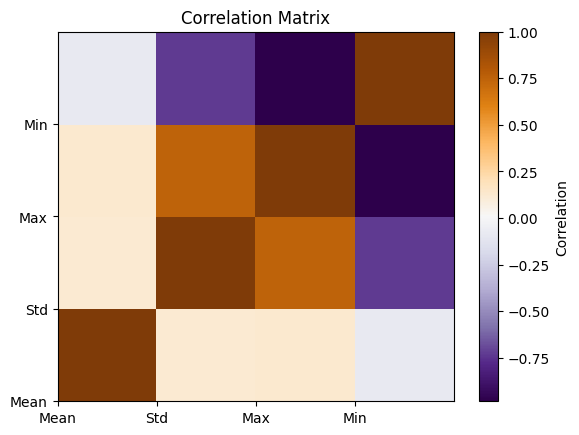

In [2]:
#put features into labeled dataframe
stats_df = pd.DataFrame(features, columns=['Mean', 'Std', 'Max', 'Min'])

#calculation correlation matrix
corr_matrix = stats_df.corr()

#display correlation matrix
plt.title('Correlation Matrix')
plt.pcolor(corr_matrix, cmap='PuOr_r')
plt.colorbar(label='Correlation')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns);

Interestingly, the Maximum and Mean seem to be the least correlated statistics, and thus might be the most useful to look at, while all of the other metrics are at least moderately correlated, and thus offer less independent information.

## Apply PCA on the selected features ##

Explained variance ratio: [0.66729267 0.24471323]


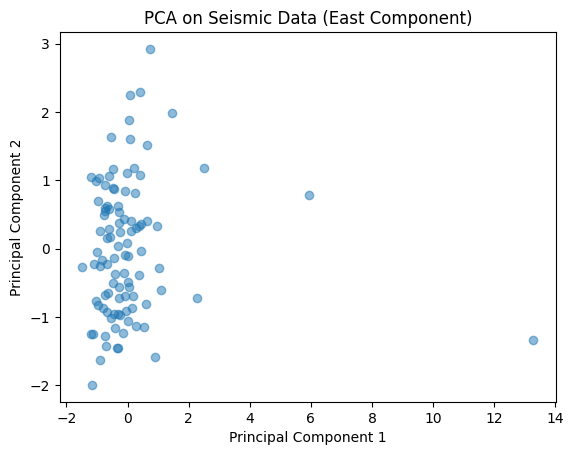

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
features_pca = pca.fit_transform(features_scaled)

print(f'Explained variance ratio: {pca.explained_variance_ratio_}')

# Visualize the results

plt.scatter(features_pca[:, 0], features_pca[:, 1], alpha = 0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA on Seismic Data (East Component)')
plt.show()

## Frequency domain representation ##

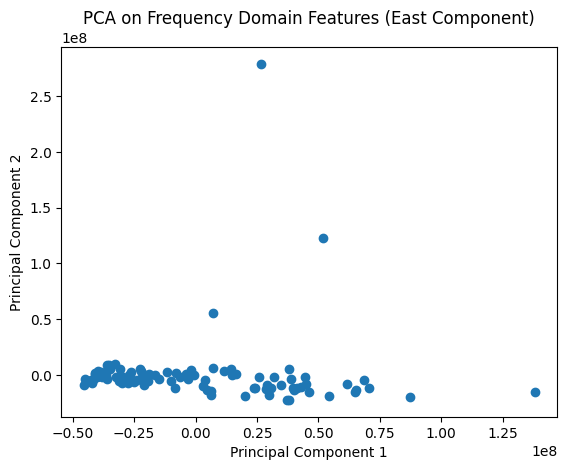

In [4]:
from scipy.fft import fft

# Apply Fourier Transform on each window
fft_features = [np.abs(fft(window))[:len(window)//2] for window in windows]

# Apply PCA on frequency features
fft_features = np.array(fft_features)
pca = PCA(n_components=2)
fft_pca = pca.fit_transform(fft_features)

# Plot the results
plt.scatter(fft_pca[:, 0], fft_pca[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA on Frequency Domain Features (East Component)')
plt.show()


### Conclusions <br>

PCA on the statistics derived from the seismic data seems particularly promising in separating out windows into common groups. The frequency derived PCA is harder to interpret, but does show linearly between the 2 principal components.